# Version information

In [1]:
%matplotlib notebook
from PySide2.QtWidgets import *
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: October 10, 2023
Pyleecan version:1.5.1
SciDataTool version:2.5.0


# Classes Glossary
This tutorials mainly uses the following classes:

- [VarParamSweep](https://pyleecan.org/pyleecan.Classes.VarParamSweep.html): Class to define a multisimulation by varying parameters
- [VarLoadCurrent](https://pyleecan.org/pyleecan.Classes.VarLoadCurrent.html): Class to define a multisimulation by varying operating point
- [DataKeeper](https://pyleecan.org/pyleecan.Classes.DataKeeper.html): Class to select some data to keep from a multi-simulation
- [ParamExplorerInterval](https://pyleecan.org/pyleecan.Classes.ParamExplorerInterval.html): Class to define a design variable (for parameter sweep) with value on an interval
- [ParamExplorerSet](https://pyleecan.org/pyleecan.Classes.ParamExplorerSet.html): Class to define a design variable (for parameter sweep) with value from a set
- [Output](https://pyleecan.org/pyleecan.Classes.Output.html): Class to  gather all the outputs of all the modules
- [XOutput](https://pyleecan.org/pyleecan.Classes.XOutput.html): Class to gathers all the outputs of all the modules for multiple simulations


# How to define a Parameter Sweep of a Variable speed simulation?
This tutorial explains how to use the objects VarParamSweep and VarLoadCurrent to run Parameter Sweep of a Variable speed simulation by using the multi-simulation tools of pyleecan. This tutorial combines several advanced aspect of pyleecan, please read the following tutorials first:

- "[How to define a machine](https://pyleecan.org/01_tuto_Machine.html)"
- "[How to define a simulation to call FEMM](https://pyleecan.org/02_tuto_Simulation_FEMM.html)".
- "[How to set the Operating Point](https://pyleecan.org/04_tuto_Operating_point.html)".
- "[How to run a multi-simulation](https://pyleecan.org/tuto_multisimulation.html)".

The multi-simulation tools of Pyleecan can be combined to create multi-simulation of multi-simulation. This tutorial will build step by step (or layer by layer) a parameter sweep to study the impact of the stator slot opening of the Toyota Prius on the variable speed torque. 

## Machine and Reference Simulation definition
The first step is to define the reference simulation aka the original machine without any modifications from the VarParamSweep (Parameter sweep object) nor the VarLoadCurrent (Variable speed object). This tutorial uses the usual machine Toyota Prius (2004) and simulation from the previous tutorials:

C:\Users\k49976\AppData\Local\Programs\pyleecan\pyleecan\Methods\Machine\Machine\plot.py:204: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


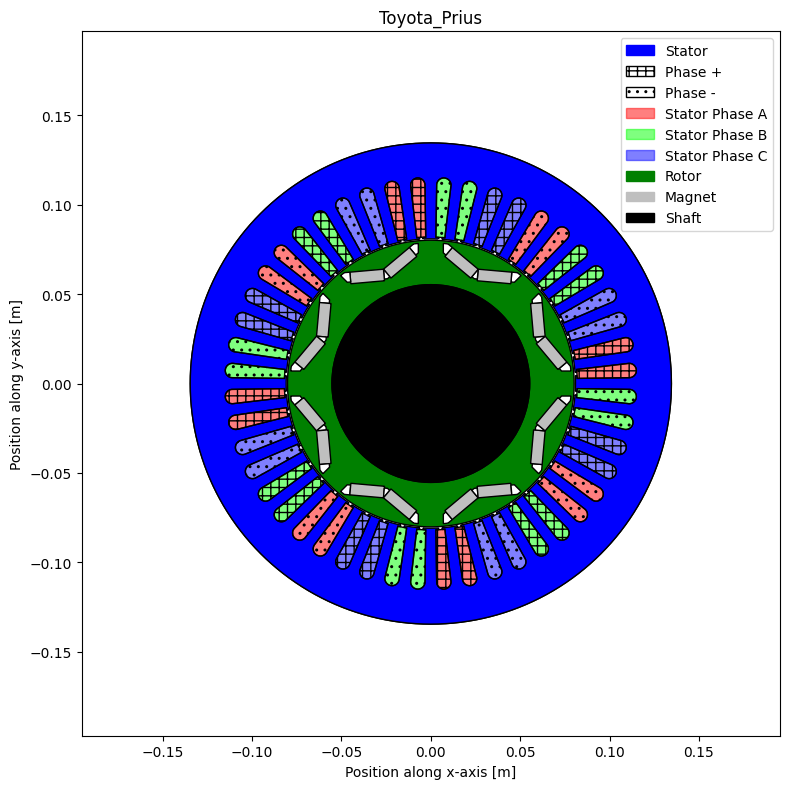

In [3]:
%matplotlib inline

# Load the machine
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from os.path import join

Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
fig, ax = Toyota_Prius.plot()

In [4]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from numpy import sqrt, pi
# Initialization of the Simulation
simu_ref = Simu1(name="tuto_multi", machine=Toyota_Prius)

# Definition of the magnetic simulation (FEMM with symmetry and sliding band)
simu_ref.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    Kgeo_fineness=1,
)
# Run only Magnetic module
simu_ref.elec = None
simu_ref.force = None
simu_ref.struct = None

simu_ref.input = InputCurrent()
simu_ref.input.Nt_tot = 128 # Number of time step
simu_ref.input.Na_tot = 2048 # Spatial discretization
# Set reference simulation operating point
simu_ref.input.OP = OPdq(N0 = 2000) # Rotor speed [rpm]
simu_ref.input.OP.Tem_av_ref = 353
simu_ref.input.OP.set_I0_Phi0(I0=250/sqrt(2), Phi0=140*pi/180)

The reference simulation "simu_ref" is now fully defined. 
It can be run before the multi-simulation to make sure that everything is correctly defined. 

The multi-simulation will copy/update the reference simulation and its results. Thus, only the minimum input/output should be modified to save memory and computation time.

The reference simulation outputs are used for comparison purpose. 

In [5]:
output_ref = simu_ref.run()

[16:48:45] Starting running simulation tuto_multi (machine=Toyota_Prius)
[16:48:45] Starting Magnetic module
[16:48:48] Computing Airgap Flux in FEMM
[16:48:55] End of simulation tuto_multi


In this tutorial we will focus on the main magnetic outputs. For example, after the reference simulation:

<IPython.core.display.Javascript object>


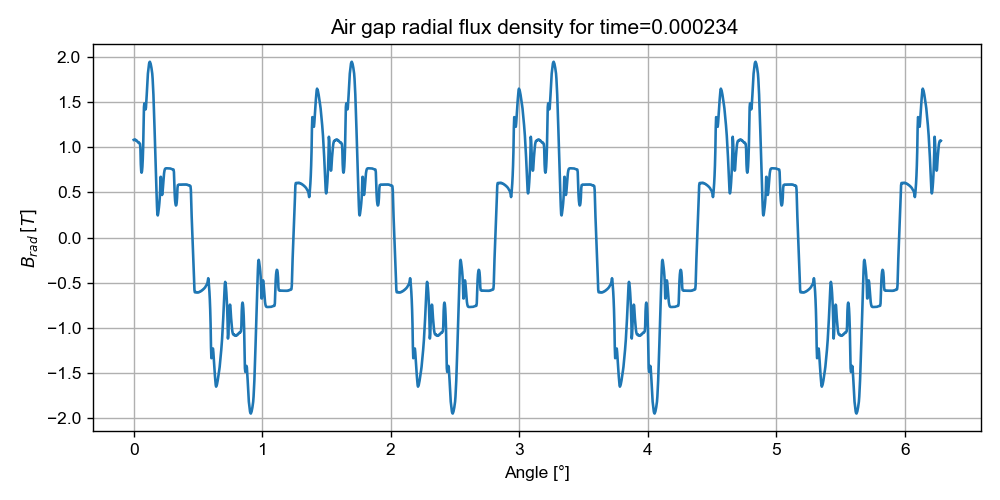

<IPython.core.display.Javascript object>


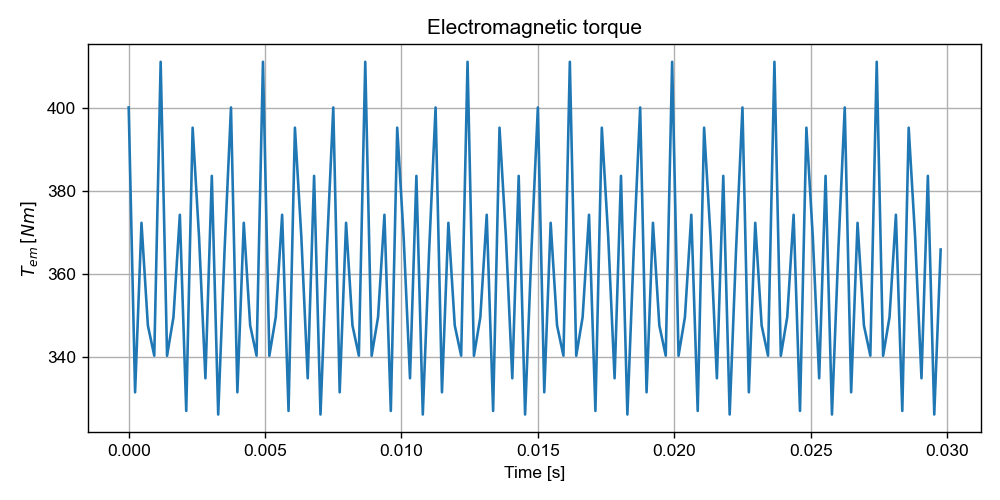

Main torque Output:
Average Electromagnetic torque [N.m]:360.6008751685237
Peak to Peak Torque ripple [N.m]:85.14729536877104
Peak to Peak Torque ripple normalized according to average torque [-]:0.23612614730615444
Torque values (with symmetry):
[400.24401909 331.47882358 372.39270218 347.61076767 340.31963689
 411.26212467 340.28986012 349.61059883 374.3362427  326.98128015
 395.36026119 369.07272321 334.86255487 383.72566552 326.1148293
 365.95191273]

Operating Point:
Rotor speed [rpm]:2000
Id [Arms]:-135.4188051049254
Iq [Arms]:113.62986941801093


In [6]:
# Flux
output_ref.mag.B.plot_2D_Data("angle","time[1]",component_list=["radial"])

# Torque
output_ref.mag.Tem.plot_2D_Data("time")
print("Main torque Output:")
print("Average Electromagnetic torque [N.m]:" +str(output_ref.mag.Tem_av))
print("Peak to Peak Torque ripple [N.m]:" +str(output_ref.mag.Tem_rip_pp))
print("Peak to Peak Torque ripple normalized according to average torque [-]:" +str(output_ref.mag.Tem_rip_norm))
print("Torque values (with symmetry):\n"+str(output_ref.mag.Tem.values))

# Operating point
print("\nOperating Point:")
print("Rotor speed [rpm]:"+str(output_ref.elec.OP.N0))
print("Id [Arms]:"+str(output_ref.elec.OP.Id_ref))
print("Iq [Arms]:"+str(output_ref.elec.OP.Iq_ref))

Although the operation point was defined with I0/Phi0, pyleecan store and use only Id/Iq.

## First multi-simulation layer: Variable speed

The next step is to define the variable speed simulation. This tutorial uses the results from: 
Z. Yang, M. Krishnamurthy and I. P. Brown, “Electromagnetic and vibrational characteristic of IPM over full torque-speed range,” 2013 International Electric Machines & Drives Conference, Chicago, IL, 2013, pp. 295-302, doi: 10.1109/IEMDC.2013.6556267.

Each pyleecan simulation is assumed to be quasi-static and run on a single operating point (fixed speed). To run a simulation on several operating points two steps are needed: 
- First define a simulation that run correctly on a single operating point (like the one defined above), 
- then define a VarLoadCurrent object. 

The VarLoadCurrent object is defined with a matrix with each line corresponding to an operating point (so each line will run a single speed simulation). The matrix columns order/containt are set by the user during the call to the method set_OP_matrix for more flexibility. Usually the first 3 columns are (N0, Id, Iq) or (N0 ,I0 ,Phi0) 

A torque column can be added by adding "Tem" as a column name. It enables to define the reference torque for the Operating Point. The reference is stored in output.elec.Tem_av_ref, the real computed torque is stored in output.mag.Tem_av.

The following VarLoadCurrent object will run the previous simulation N_simu times by changing the value of Phi0. 

Reference torque and current angle vector are:

In [5]:
from numpy import linspace, array, pi

Tem_av_ref = array([79, 125, 160, 192, 237, 281, 319, 343, 353, 332, 266, 164, 22]) # Yang et al, 2013
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, Tem_av_ref.size)
N_speed = Tem_av_ref.size

In [6]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from numpy import zeros, ones, linspace, array, sqrt, arange

simu_vop = simu_ref.copy()
simu_vop.mag.import_file = None
varload = VarLoadCurrent()
simu_vop.var_simu = varload

# Creating the Operating point matrix
OP_matrix = zeros((N_speed,4))

# Set N0 = 2000 [rpm] for all simulation
OP_matrix[:,0] = 2000 * ones((N_speed))

# Set I0 = 250 / sqrt(2) [A] (RMS) for all simulation
OP_matrix[:,1] = 250/sqrt(2) * ones((N_speed)) 

# Set Phi0 from 60° to 180°
OP_matrix[:,2] = Phi0_ref

# Set reference torque from Yang et al, 2013
OP_matrix[:,3] = Tem_av_ref

print("Operating Point matrix:")
print(OP_matrix)
print("Original Operating point:")
print(simu_vop.input.OP.get_I0_Phi0())

# Column name are given in the order of OP_matrix
varload.set_OP_array(OP_matrix, "N0", "I0", "Phi0", "Tem")

# The operating point of the simulation is automatically set as
# the first one from the OP_matrix
print("Updated Operating point:")
print(simu_vop.input.OP.get_I0_Phi0())

# All the simulation use the same machine
# No need to draw the machine for all OP
varload.is_reuse_femm_file=True  

Operating Point matrix:
[[2.00000000e+03 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [2.00000000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [2.00000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.00000000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [2.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [2.00000000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [2.00000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [2.00000000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [2.00000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]
 [2.00000000e+03 1.76776695e+02 2.61799388e+00 3.32000000e+02]
 [2.00000000e+03 1.76776695e+02 2.79252680e+00 2.66000000e+02]
 [2.00000000e+03 1.76776695e+02 2.96705973e+00 1.64000000e+02]
 [2.00000000e+03 1.76776695e+02 3.14159265e+00 2.20000000e+01]]
Original Operating point:
{'I0': 176.77669529663686, 'Phi0': 2.443460952792061}
Updated Operating point:
{'I0': 176.77669529663686, 'Phi0': 1.04719755119659

This first layer will behave as follow:
- First the reference simulation will be run to get the reference output,
- then the reference simulation will be duplicated N_speed times with the value of InputCurrent updated according to the OP matrix. 
- is_reuse_femm will update the N_speed simulations to reuse the FEMM file drawn in the reference simulation to speed-up the computations.
- Each simulation of the list will be run separately and the results gathered in an XOutput object.

Pyleecan can detect that a simulation from the list matches the reference one and skip its computation to avoid computing twice the same thing. When defining a multi-simulation of multi-simulation, this optimization is essential since pyleecan will run "1 + (N_speed-1)" simulations instead of "1 + N_speed" for each combinaison of the design parameters. This is why the call to set_OP_matrix has overwrite the OP of the original simulation by the first OP of the matrix to make sure that we are in the "1 + (N_speed -1)" case. set_OP_matrix has two optional argument: 
- To disable this behavior "is_update_input=False"
- To select another OP, "input_index=X" with X the matrix line number to use

To further understand pyleecan multi-simulation tools, this tutorial uses the option "is_keep_all_output" that keeps all the output of all the simulations. This option enables to access the plot for all the Operating Points but can take significant memory space depending on the simulation.

In [7]:
simu_vop.var_simu.is_keep_all_output = True

# Add I0/Phi0 to the data available at the end of the simulation
from pyleecan.Classes.DataKeeper import DataKeeper
I0_dk = DataKeeper(
    name="Stator current rms amplitude",
    symbol="I0",
    unit="Arms",
    keeper="lambda output: output.elec.OP.get_I0_Phi0()['I0']",
)
Phi0_dk = DataKeeper(
    name="Stator current phase",
    symbol="Phi0",
    unit="rad",
    keeper="lambda output: output.elec.OP.get_I0_Phi0()['Phi0']",
)
varload.datakeeper_list = [I0_dk, Phi0_dk]

In [10]:
Xout_vop = simu_vop.run()

[16:49:29] Starting running simulation tuto_multi (machine=Toyota_Prius)
[16:49:29] Computing reference simulation for Variable Load
[16:49:29] Starting Magnetic module
[16:49:32] Computing Airgap Flux in FEMM
[16:49:38] Variable Load Reference Results: I0=176.8 [Arms], Phi0=1.047 [rad], N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms], Tem_av_ref=79 [N.m], Tem_av=90.37 [N.m], Tem_rip_pp=30.72 [N.m], Tem_rip_norm=0.34 [-], Pem_av=1.893e+04 [W]
[===                                               ]   7%
[16:49:38] Variable Load: Using same FEMM file for all simulations (C:\Users\LAP21\Documents\pyleecan-public2\pyleecan\Results\tuto_multi\Femm\Toyota_Prius_model.fem)
[16:49:38] Running simulation 1/13 with N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms]
[16:49:38] Simulation matches reference one: Skipping computation
[16:49:38] Variable Load Results: I0=176.8 [Arms], Phi0=1.047 [rad], N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms], Tem_av_ref=79 [N.m], Tem_av=90.37 [N.m], Tem_rip_pp=30.7

The log of the simulation enables to understand step by step the status of the computation. As expected, the reference simulation is computed first. Then each of the 13 simulations is run starting with a message indicating the simulation operating point:

**Running simulation 3/13 with N0=2000 [rpm], Id=30.7 [Arms], Iq=174.1 [Arms]**

And ending with the Datakeepers result for this simulation:

**Variable Load Results: N0=2000 [rpm], Id=30.7 [Arms], Iq=174.1 [Arms], I0=176.8 [A], Phi0=1.396 [], Tem_av_ref=160 [N.m], Tem_av=170.3 [N.m], Tem_rip_pp=53.12 [N.m], Tem_rip_norm=0.312 [-]**

As expected the computation for the first simulation was skipped, the operating point and Datakeepers are still displayed as a reminder.

Pyleecan will automatically defines several Datakeeper to extract the main outputs from each simulation, we have manually added I0 and Phi0. These values are all gathered in the xoutput_dict:

In [11]:
print("Values available in XOutput:")
print(Xout_vop.xoutput_dict.keys())

print("\nI0 for each simulation:")
print(Xout_vop["I0"].result)
print("\nPhi0 for each simulation:")
print(Xout_vop["Phi0"].result)
print("\nComputed Average Torque for each simulation:")
print(Xout_vop["Tem_av"].result)
print("\nComputed Average Torque of the reference simulation:")
print(Xout_vop["Tem_av"].result_ref)

Values available in XOutput:
dict_keys(['I0', 'Phi0', 'N0', 'Id', 'Iq', 'Tem_av_ref', 'Tem_av', 'Tem_rip_pp', 'Tem_rip_norm', 'Pem_av'])

I0 for each simulation:
[176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663683, 176.77669529663686]

Phi0 for each simulation:
[1.0471975511965976, 1.2217304763960306, 1.3962634015954636, 1.5707963267948966, 1.7453292519943295, 1.9198621771937625, 2.0943951023931957, 2.2689280275926285, 2.443460952792061, 2.6179938779914944, 2.7925268031909276, 2.9670597283903604, 3.141592653589793]

Computed Average Torque for each simulation:
[90.3709250122835, 134.07947199821788, 178.95317285731952, 222.95208815546215, 264.1993260193586, 300.9664347929566, 331.328958899423, 352.7449529546559, 360.6008751685237, 343.4534568699727, 276.61962317091206, 157.02492548028775, -0.4102213992

As expected the average torque of the reference simulation is the same as the first simulation.

As the option is_keep_all_output was activated, one can also access all the simulation results in the "output_list":

Id: 30.69695099224322 , Iq: 174.0910600800047 , Tem_av_ref: 160.0


<IPython.core.display.Javascript object>


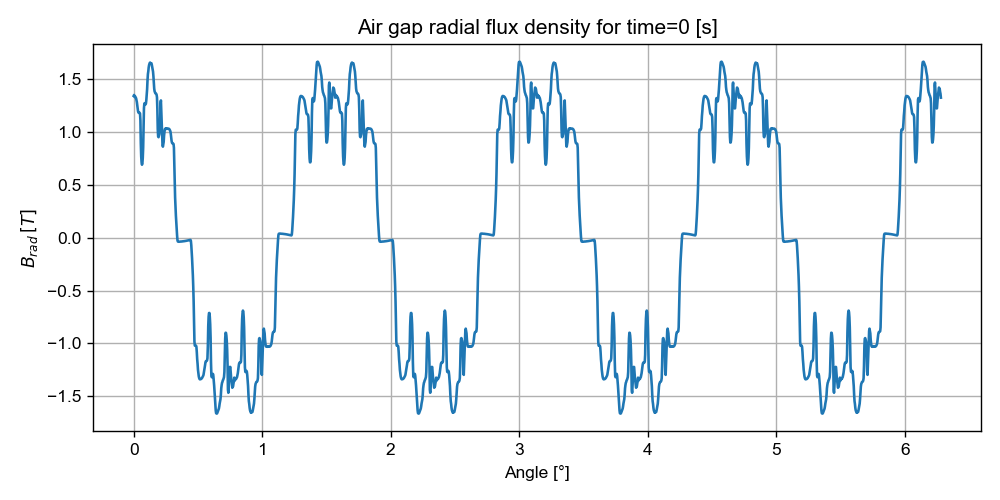

<IPython.core.display.Javascript object>


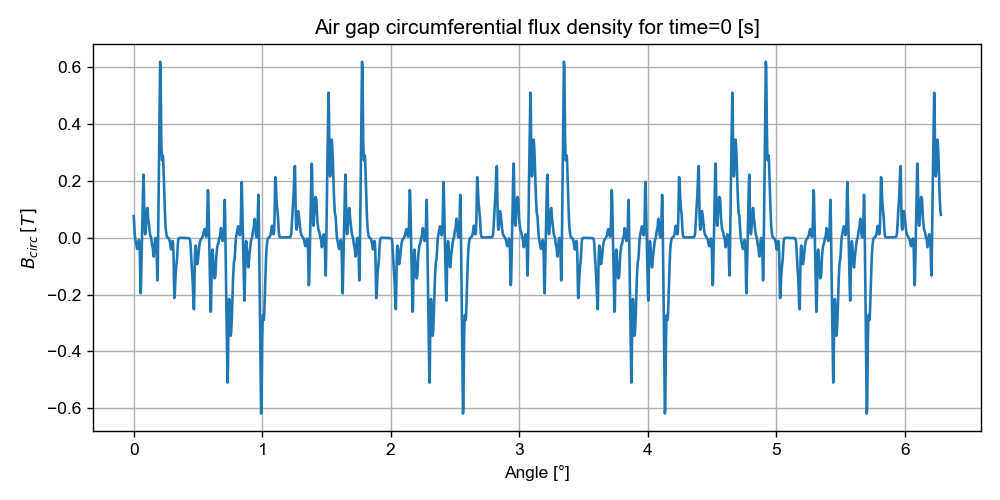

Index of the reference simulation in the list: 0
Id: 88.38834764831844 , Iq: 153.0931089239486 , Tem_av_ref: 79.0


<IPython.core.display.Javascript object>


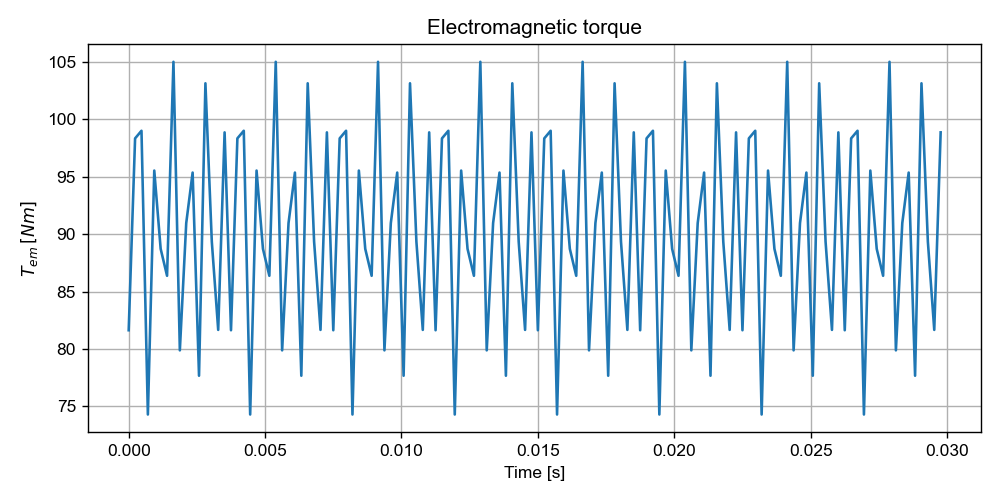

In [12]:
# Flux of the 3rd simulation
print("Id: "+str(Xout_vop.output_list[2].elec.OP.Id_ref)+" , Iq: "+str(Xout_vop.output_list[2].elec.OP.Iq_ref)+" , Tem_av_ref: "+str(Xout_vop.output_list[2].simu.input.OP.Tem_av_ref))
Xout_vop.output_list[2].mag.B.plot_2D_Data("angle")

print("Index of the reference simulation in the list: "+str(Xout_vop.xoutput_ref_index))
print("Id: "+str(Xout_vop.output_list[0].elec.OP.Id_ref)+" , Iq: "+str(Xout_vop.output_list[0].elec.OP.Iq_ref)+" , Tem_av_ref: "+str(Xout_vop.output_list[0].simu.input.OP.Tem_av_ref))
Xout_vop.output_list[0].mag.Tem.plot_2D_Data("time")

Any parameter in the xOutput_dict can be plot as a function of any other

<IPython.core.display.Javascript object>


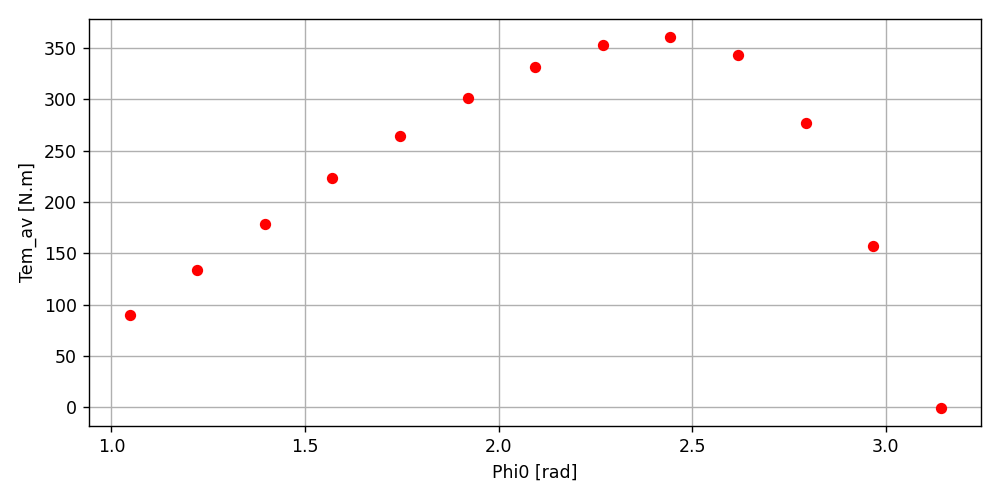

<IPython.core.display.Javascript object>


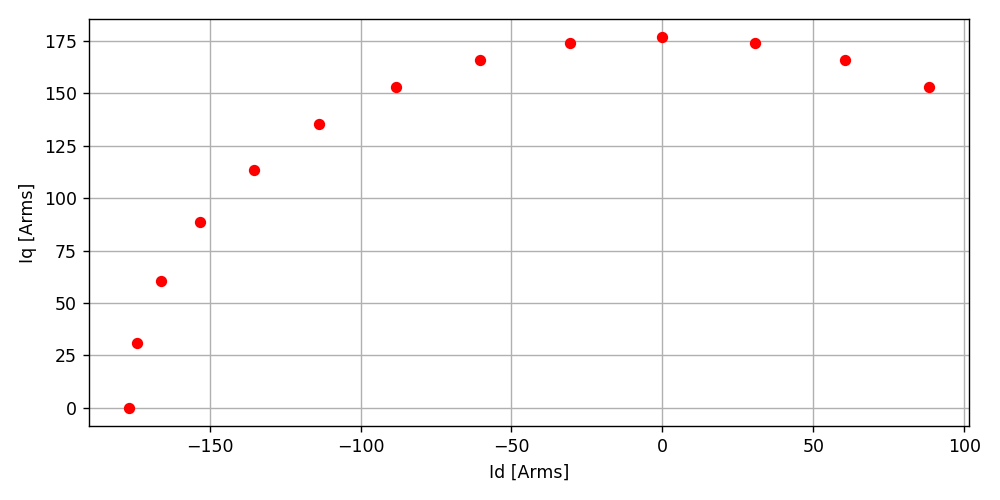

In [13]:
fig = Xout_vop.plot_multi("Phi0", "Tem_av")
fig = Xout_vop.plot_multi("Id", "Iq")

## Second multi-simulation layer only: Parameter Sweep

In pyleecan a Parameter Sweep is defined with a VarParamSweep object. The design variables are set with ParamExplorer objects and the same Datakeeper as for a VarLoadCurrent (Id, Id, Tem_av...) will be automatically defined as output. Other Datakeepers can be defined in simu.var_simu.datakeeper_list.

VarParamSweep and VarLoadCurrent inherit from the same class VarSimu. This is why most of the parameter of VarLoadCurrent are also available in VarParamSweep and that both classes share the same behaviour. The main difference is how the simulation list is defined. Technically a VarLoadCurrent could be defined with a VarParamSweep using ParamExplorer on Id / Iq / Tem_av_ref.

For this tutorial, only one ParamExplorer is defined: a linspace on the stator slot opening. The is_reuse_femm_file is desactivated as each simulation will have a different machine and is_keep_all_output is activated to show the full content of the xoutput object.

In [8]:
from pyleecan.Classes.VarParamSweep import VarParamSweep
from pyleecan.Classes.ParamExplorerInterval import ParamExplorerInterval

simu_sweep = simu_ref.copy()
simu_sweep.mag.import_file = None

# Multi-simulation to change machine parameters
sweep = VarParamSweep(
    stop_if_error=True,
    is_reuse_femm_file=False,
    is_keep_all_output=True,
)
simu_sweep.var_simu = sweep
N_sweep = 8

# List of ParamExplorer to define multisimulation input values
simu_sweep.var_simu.paramexplorer_list = [
    ParamExplorerInterval(
        name="Stator slot opening",
        symbol="W0s",
        unit="m",
        setter="simu.machine.stator.slot.W0",
        getter="simu.machine.stator.slot.W0",
        min_value=0.1 * Toyota_Prius.stator.slot.W0,
        max_value=1.4 * Toyota_Prius.stator.slot.W0,
        N=N_sweep,
    )
]

print("Value used in the Parameter sweep: "+str(simu_sweep.var_simu.paramexplorer_list[0].get_value()))
print("Reference machine W0: "+str(Toyota_Prius.stator.slot.W0))

Value used in the Parameter sweep: [0.000193   0.00055143 0.00090986 0.00126829 0.00162671 0.00198514
 0.00234357 0.002702  ]
Reference machine W0: 0.00193


In [15]:
Xout_sweep = simu_sweep.run()

[16:51:17] Starting running simulation tuto_multi (machine=Toyota_Prius)
[16:51:17] Computing reference simulation for Parameter Sweep
[16:51:17] W0s: 8 values from 0.000193 to 0.002702 (ref=0.00193) [m]
[16:51:17] Starting Magnetic module
[16:51:19] Computing Airgap Flux in FEMM
[16:51:25] Parameter Sweep Reference Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=360.6 [N.m], Tem_rip_pp=85.15 [N.m], Tem_rip_norm=0.2361 [-], Pem_av=7.552e+04 [W]
[=====                                             ]  11%
[16:51:25] Running simulation 1/8 with W0s=0.000193
[16:51:25] Starting Magnetic module
[16:51:27] Computing Airgap Flux in FEMM
[16:51:33] Parameter Sweep Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=352.3 [N.m], Tem_rip_pp=89.39 [N.m], Tem_rip_norm=0.2538 [-], Pem_av=7.378e+04 [W]
[===========                                       ]  22%
[16:51:33] Running simulation 2/8 with W0s=0.00055142857
[16:51:33] Starting Magnetic module
[16:51:34] Computin

The log of the simulation enables to understand step by step the status of the computation. As expected, the reference simulation is computed first (which is still on a single operating point). Then, each of the 8 simulations (ref W0s in not in the value list) is run on the same operating point with a different value for the stator slot opening displayed as:

**Running simulation 7/8 with W0s=0.0020127143**

And ending with the datakeepers result for this simulation:

**Parameter Sweep Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=353.8 [N.m], Tem_rip_pp=82.94 [N.m], Tem_rip_norm=0.2344 [-]**
    
When is_keep_all_output is True, the reference output is either stored in the output_list if one of the N simulation matches the reference one or in xoutput_ref otherwise

In [16]:
print("Xout_sweep.xoutput_ref:" +str(type(Xout_sweep.xoutput_ref)))
print("Xout_sweep.xoutput_ref_index:" +str(Xout_sweep.xoutput_ref_index))
print("\nXout_vop.xoutput_ref:" +str(Xout_vop.xoutput_ref))
print("Xout_vop.xoutput_ref_index:" +str(Xout_vop.xoutput_ref_index))

# A function enables to acces the reference output in all the cases
xoutput_ref = Xout_sweep.get_xoutput_ref()

Xout_sweep.xoutput_ref:<class 'pyleecan.Classes.Output.Output'>
Xout_sweep.xoutput_ref_index:None

Xout_vop.xoutput_ref:None
Xout_vop.xoutput_ref_index:0


output_list, xoutput_dict and the respective plot commands work the same way as for VarLoadCurrent. The ParamExplorer are also available for plot_multi:

<IPython.core.display.Javascript object>


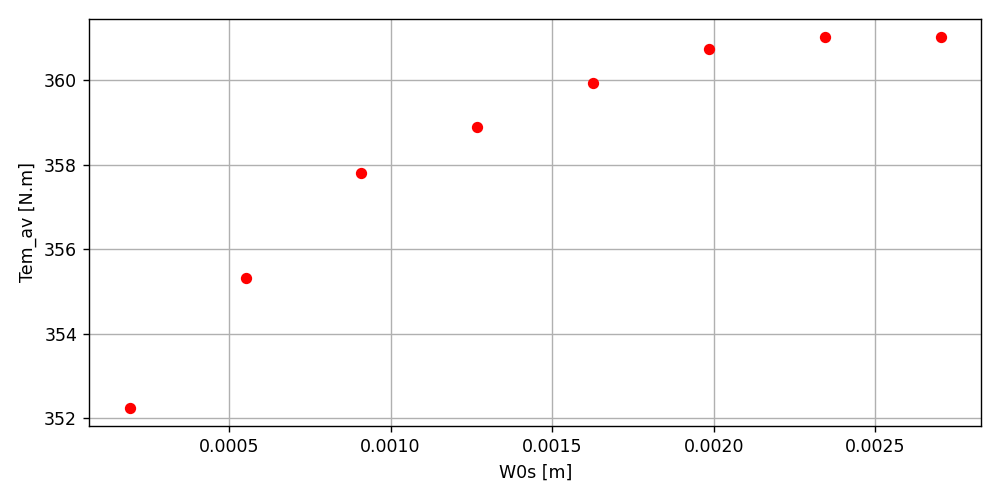

In [17]:
fig, ax = Xout_sweep.plot_multi("W0s","Tem_av")

As a reminder, each output contains the simulation that computed it. Using Parameter sweep with is_keep_all_output enables to access each generated simulation and machine in the output_list. The following code will extract the machine with the highest torque. To get the corresponding W0s, the ParamExplorerInterval was converted to a ParamExplorerSet to store the actual values used during the simulation. 

In [9]:
from numpy import argmax, max as np_max
# Find the simulation with the most torque
Tmax = np_max(Xout_sweep.xoutput_dict["Tem_av"].result)
Tmax_id = int(argmax(Xout_sweep.xoutput_dict["Tem_av"].result))
print("Max Torque is "+str(Tmax)+" [N.m], for simulation index "+str(Tmax_id))

# Find the corresponding W0s
print(type(Xout_sweep.paramexplorer_list[0]))
W0s_val = Xout_sweep.paramexplorer_list[0].get_value()
print(W0s_val)

print("Corresponding W0s is " + str(W0s_val[Tmax_id]))

# To save the simulation or machine for further modifications/computations
# Xout_sweep.output_list[Tmax_id].simu.save(path/to/json/file)
# Xout_sweep.output_list[Tmax_id].simu.machine.save(path/to/json/file)

NameError: name 'Xout_sweep' is not defined

It is also possible to access the machine plot command to check the modifications:

<IPython.core.display.Javascript object>


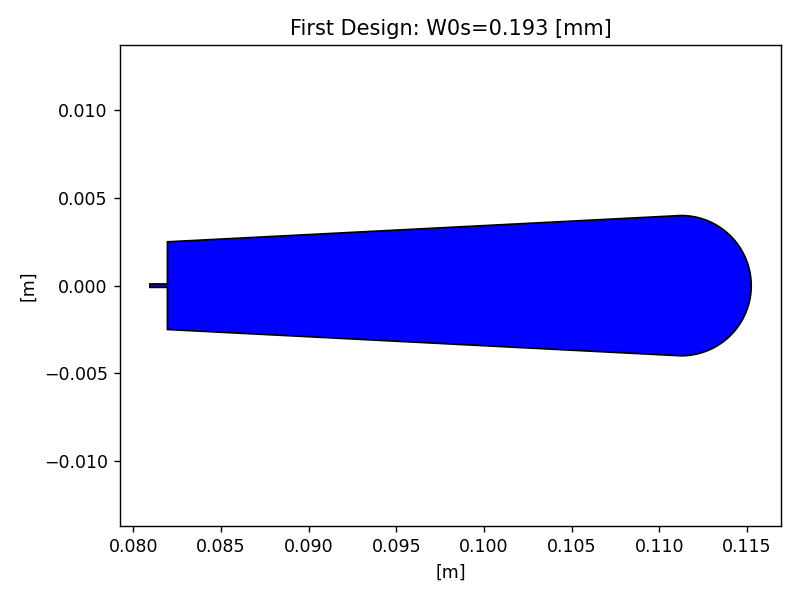

<IPython.core.display.Javascript object>


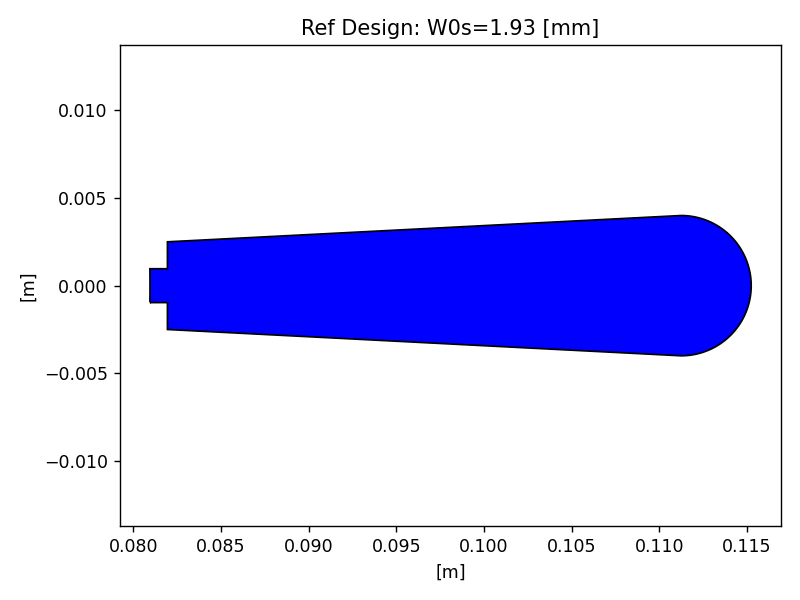

<IPython.core.display.Javascript object>


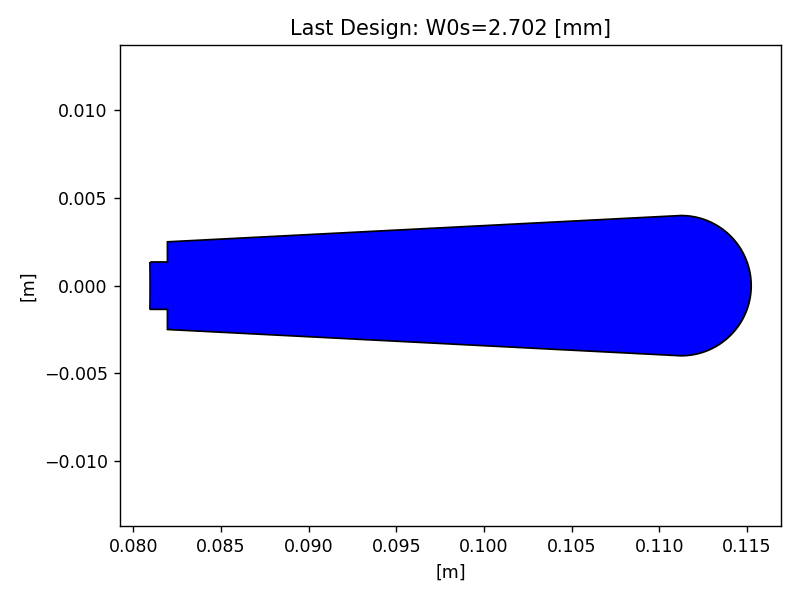

Text(0.5, 1.0, 'Last Design: W0s=2.702 [mm]')

In [19]:
fig,ax = Xout_sweep.output_list[0].simu.machine.stator.slot.plot()
ax.set_title("First Design: W0s="+format(Xout_sweep.output_list[0].simu.machine.stator.slot.W0*1000, ".4g")+ " [mm]")

fig,ax = Xout_sweep.xoutput_ref.simu.machine.stator.slot.plot()
ax.set_title("Ref Design: W0s="+format(Xout_sweep.xoutput_ref.simu.machine.stator.slot.W0*1000, ".4g")+ " [mm]")

fig,ax = Xout_sweep.output_list[-1].simu.machine.stator.slot.plot()
ax.set_title("Last Design: W0s="+format(Xout_sweep.output_list[-1].simu.machine.stator.slot.W0*1000, ".4g")+ " [mm]")

## Both multi-simulation layers: Parameter-sweep of variable speed simulation

For now, we have set the var_simu property of Simulation with a VarSimu object to define a multi-simulation. To define a multi-simulation of multi-simulation, we can use the var_simu property of VarSimu which also take a VarSimu object. This definition principal has no limit in the number of "simulation layer" but no usage should require more than two layers.

In [10]:
multi_simu = simu_ref.copy()
multi_simu.mag.import_file=None
multi_simu.var_simu = sweep.copy()
multi_simu.var_simu.var_simu = varload.copy()

The workflow of this simulation is the following:
- Pyleecan checks simu.var_simu => VarParamSweep.run
- VarParamSweep defines its reference simulation with simu.var_simu = simu.var_simu.var_simu
- VarParamSweep run its referencece simulation, check simu.var_simu => VarLoadCurrent.run
- The reference simulation of VarParamSweep is a VarLoadCurrent simulation that defines its own reference simulation with simu.var_simu = simu.var_simu.var_simu (which is None)
- When running the reference simulation of VarLoadCurrent, simu.var_simu is None so we run the models (this simulation is then exaclty simu_ref defined previously)
- Pyleecan run the N_speed simulations of the VarLoadCurrent
- Pyleecan generates the N_sweep simulations of the VarParamSweep which are VarLoadCurrent and run them all
- For each VarLoadCurrent simulation, a reference simulation is defined then the N_speed simulations

So this simulation will run (1+N_sweep) * (1+N_speed) simulations. This is why it is important to make sure that the reference simulation is part of the N simulations to skip one computation on both sides.

Each simulation layer has its own properties which enables to do the following:

In [11]:
# VarParamSweep => All machine are different
multi_simu.var_simu.is_reuse_femm_file = False
# VarLoadCurrent => All machines are the same
multi_simu.var_simu.var_simu.is_reuse_femm_file = True

To explain the output structure, this tutorial will again use the is_keep_all_output option. To speed up the computation and reduce the memory usage the number of simulation is reduced:

In [28]:
# VarParamSweep
multi_simu.var_simu.is_keep_all_output = True
multi_simu.var_simu.datakeeper_list = list()  # reset datakeeper list
multi_simu.var_simu.paramexplorer_list[0].N = 4
multi_simu.var_simu.paramexplorer_list[0].max_value = Toyota_Prius.stator.slot.W0  # Ref is in the N simu
# VarLoadCurrent
multi_simu.var_simu.var_simu.is_keep_all_output = True
# reset datakeeper list
I0_dk = DataKeeper(
    name="Stator current rms amplitude",
    symbol="I0",
    unit="Arms",
    keeper="lambda output: output.elec.OP.get_I0_Phi0()['I0']",
)
Phi0_dk = DataKeeper(
    name="Stator current phase",
    symbol="Phi0",
    unit="rad",
    keeper="lambda output: output.elec.OP.get_I0_Phi0()['Phi0']",
)
multi_simu.var_simu.var_simu.datakeeper_list = [I0_dk, Phi0_dk]
multi_simu.var_simu.var_simu.set_OP_array(OP_matrix[:-4, :], "N0", "I0", "Phi0", "Tem")
print("OP matrix")
print(OP_matrix[:-4, :])
print(OP_matrix)
# Reference simulation
multi_simu.input.Nt_tot = 64

OP matrix
[[ 2.00000000e+003  9.19893308e-003 -3.72216083e-015  7.90000000e+001]
 [ 2.00000000e+003  9.96977423e-003  6.05226267e-010  1.25000000e+002]
 [ 2.00000000e+003  1.63329770e-002  1.41261519e-014  1.60000000e+002]
 [ 2.00000000e+003  7.16420885e-015  2.89025838e-156  1.92000000e+002]
 [ 2.00000000e+003 -1.63329770e-002 -1.41261519e-014  2.37000000e+002]
 [ 2.00000000e+003 -9.96977433e-003 -6.05226297e-010  2.81000000e+002]
 [ 2.00000000e+003 -9.19893308e-003  3.72216083e-015  3.19000000e+002]
 [ 2.00000000e+003 -1.99228115e-001 -1.28910698e-003  3.43000000e+002]
 [ 2.00000000e+003  9.65144977e-002 -8.94435478e-004  3.53000000e+002]]
[[ 2.00000000e+003  9.19893308e-003 -3.72216083e-015  7.90000000e+001]
 [ 2.00000000e+003  9.96977423e-003  6.05226267e-010  1.25000000e+002]
 [ 2.00000000e+003  1.63329770e-002  1.41261519e-014  1.60000000e+002]
 [ 2.00000000e+003  7.16420885e-015  2.89025838e-156  1.92000000e+002]
 [ 2.00000000e+003 -1.63329770e-002 -1.41261519e-014  2.37000000e+

For a better understanding of the logs, the VarLoadCurrent simulation log can be filtered with:

In [19]:
multi_simu.layer_log_warn = 2

In [20]:
Xout_multi = multi_simu.run()

[08:17:16] Starting running simulation tuto_multi (machine=Toyota_Prius)


[08:17:16] Computing reference simulation for Parameter Sweep
[08:17:16] W0s: 4 values from 0.000193 to 0.00193 (ref=0.00193) [m]
[08:17:16]     Computing reference simulation for Variable Load
[08:17:22]     Variable Load Reference Results: I0=0.009199 [Arms], Phi0=6.283 [rad], N0=2000 [rpm], Id=0.009199 [Arms], Iq=-5.198e-07 [Arms], Tem_av_ref=79 [N.m], Tem_av=0.009166 [N.m], Tem_rip_pp=0.8986 [N.m], Tem_rip_norm=98.04 [-], Pem_av=1.92 [W]
               [=====                                             ]  10%
[08:17:23]     Variable Load: Using same FEMM file for all simulations (C:\Users\k49976\AppData\Local\Programs\pyleecan\pyleecan\Results\tuto_multi\Femm\Toyota_Prius_model.fem)
[08:17:23]     Running simulation 1/9 with N0=2000 [rpm], Id=0.009199 [Arms], Iq=-5.198e-07 [Arms]
[08:17:23]     Simulation matches reference one: Skipping computation
[08:17:23]     Variable Load Results: I0=0.009199 [Arms], Phi0=6.283 [rad], N0=2000 [rpm], Id=0.009199 [Arms], Iq=-5.198e-07 [Arms], Te

Again, the logs enable to follow step by step each layer of the simulation with their corresponding input and output.
The datakeeper of the VarLoadCurrent are the same as previously:
**Variable Load Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=353 [N.m], Tem_av=353.3 [N.m], Tem_rip_pp=73.53 [N.m], Tem_rip_norm=0.2081 [-]**

But the VarParamSweep Datakeeper are now:

**Parameter Sweep Results: Max_Tem_av=345 [N.m], Max_Tem_rip_pp=90.72 [N.m], Max_Tem_rip_norm=0.3105 [-]**

The reason is that now the parameter sweep is running on a multi-simulation. Thus, Tem_av is now an array as a function of the operating point. So instead of storing Tem_av, the datakeeper now store the maximum of the Tem_av DataKeeper of the VarLoadCurrent simulation ("max(output.xoutput_dict['Tem_av'].result)")

The xoutput_dict contains only the information related to the VarParm:

Values available in XOutput:
dict_keys(['Max_Tem_av', 'Max_Tem_rip_pp', 'Max_Tem_rip_norm'])

Maximum Torque for each Design:
[0.09945216984272187, 0.10059240351599777, 0.0885620142591213, 0.11749649786637889]
W0s for each Design:
[0.00019300000000000003, 0.000772, 0.001351, 0.00193]


c:\Users\k49976\AppData\Local\Programs\Python\Python39\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 800x400 with 1 Axes>,
 <AxesSubplot:xlabel='W0s [m]', ylabel='Max_Tem_av [N.m]'>)

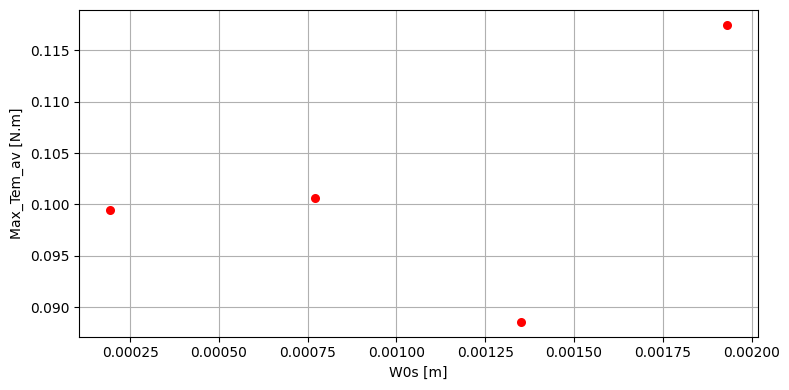

In [21]:
print("Values available in XOutput:")
print(Xout_multi.xoutput_dict.keys())

print("\nMaximum Torque for each Design:")
print(Xout_multi.xoutput_dict["Max_Tem_av"].result)
print("W0s for each Design:")
print(Xout_multi.paramexplorer_list[0].get_value())

Xout_multi.plot_multi("W0s", "Max_Tem_av")

In [22]:
Xout_multi.xoutput_dict["Max_Tem_av"].result

[0.09945216984272187,
 0.10059240351599777,
 0.0885620142591213,
 0.11749649786637889]

As the is_keep_all_output option was activated, output_list is available but now it contains the xouput resulting from the VarLoadCurrent computation. Then all the VarLoadCurrent DataKeeper are available.

In [23]:
print(type(Xout_multi.output_list[0]))
print(type(Xout_sweep.output_list[0]))

print("\nDatakeeper of VarLoadCurrent simulation of Design 0")
print(Xout_multi.output_list[0].xoutput_dict.keys())
print("Average torque for each operating point of Design 0")
print(Xout_multi.output_list[0].xoutput_dict["Tem_av"].result)

# To save the VarLoadCurrent simulation or machine for further modifications/computations
# Xout_multi.output_list[0].simu.save(path/to/json/file)
# Xout_multi.output_list[0].simu.machine.save(path/to/json/file)

<class 'pyleecan.Classes.XOutput.XOutput'>


NameError: name 'Xout_sweep' is not defined

As the VarLoadCurrent also have the is_keep_all_output option activated, the output of each simulation is available and  it is possible to call the corresponding plot command

c:\Users\k49976\AppData\Local\Programs\Python\Python39\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\k49976\AppData\Local\Programs\Python\Python39\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\k49976\AppData\Local\Programs\Python\Python39\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\k49976\AppData\Local\Programs\Python\Python39\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.back

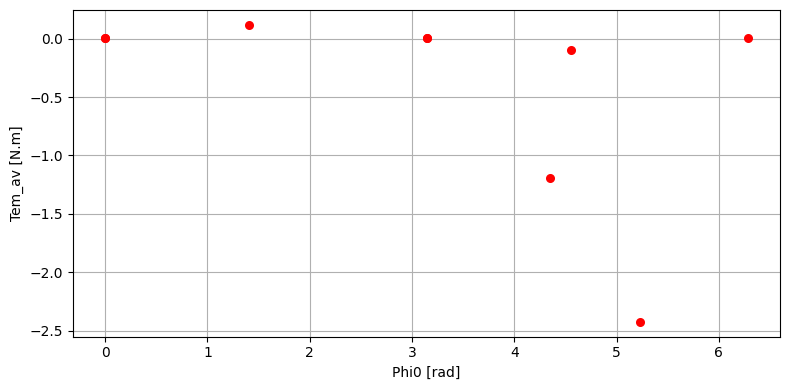

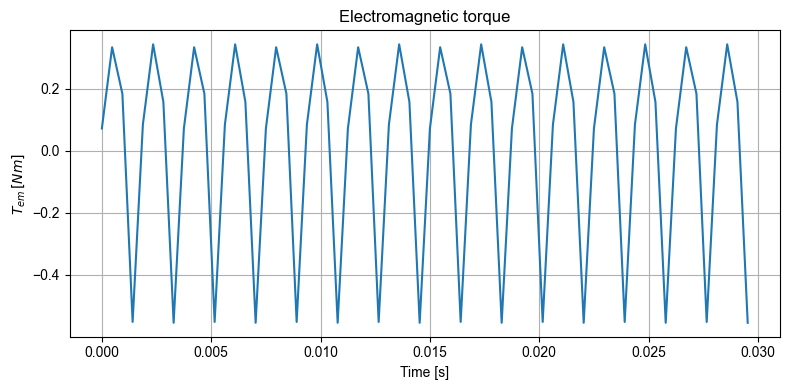

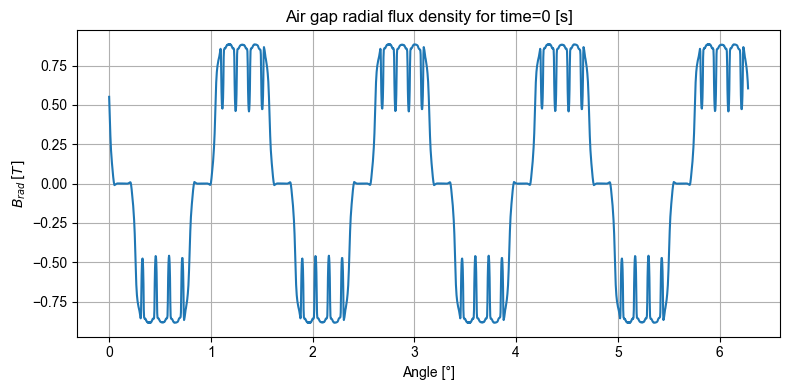

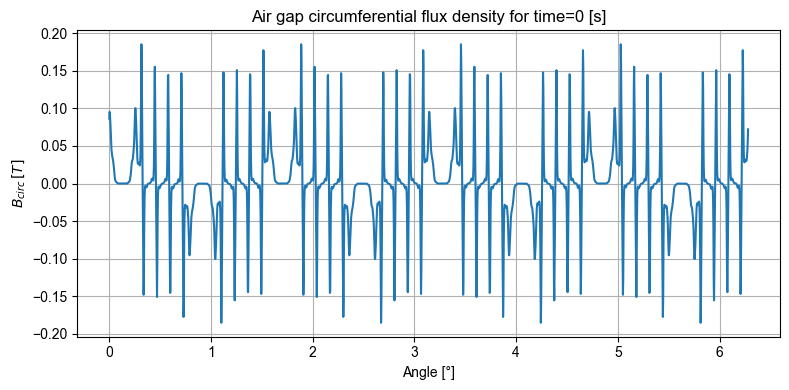

In [24]:
Xout_multi.output_list[-1].plot_multi("Phi0", "Tem_av")
# Torque at the first Operating point for the Last design
Xout_multi.output_list[-1].output_list[0].mag.Tem.plot_2D_Data("time")
# Flux of the 4th Operating point for the Last design
Xout_multi.output_list[-1].output_list[3].mag.B.plot_2D_Data("angle")
